In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn


In [3]:
import tensorflow as tf
from tensorflow import keras

### Setting up a virtual GPU

In [2]:
# Creating a virtual GPU. Got the code block from the Tensorflow documentation
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

NameError: name 'tf' is not defined

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Problem statement:

Train a deep MLP on the MNIST dataset(you can load it using keras.datasets.mnist.load_data()). See if you can get over 98% precision. try searching for the optimal learning rate by using the approach presented in this chapter(i.e., by growing the learning rate exponentially, plotting the error, and finding the point where the error shoots up.) Try adding all the bells and whistles-save checkpoints, use early stopping and plot learning curves using Tensorboard.

In [6]:
import numpy as np

In [7]:
data = keras.datasets.mnist.load_data()

In [62]:
(X_train_full, Y_train_full), (x_test, y_test) = data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (50000, 28, 28)
y_train (50000,)
x_test (10000, 28, 28)
y_test (10000,)


In [63]:
x_train, x_valid = X_train_full[:55000]/255., X_train_full[55000:]/255.
y_train, y_valid = Y_train_full[:55000], Y_train_full[55000:]

In [64]:
x_train.shape[1:]

(28, 28)

In [93]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
#         print(self.model.summary())
#         self.model = model
        self.rates = []
        self.losses = []
        self.factor = factor
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [94]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [95]:
model = tf.keras.Sequential([keras.layers.Flatten(input_shape=[28, 28]), 
                            keras.layers.Dense(units=300, activation="relu"),
                            keras.layers.Dense(units=100, activation="relu"),
                            keras.layers.Dense(units=10, activation="softmax")])

In [96]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [97]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.fit(x_train, y_train, epochs=1, 
          validation_data=(x_valid, y_valid), 
          callbacks=[expon_lr])

1563/1563 [==============================] - 7s 4ms/step - loss: 144370515153130014900224.0000 - accuracy: 0.6431 - val_loss: 2.3445 - val_accuracy: 0.0990


Text(0.5, 0, 'learning_rates')

Text(0, 0.5, 'losses')

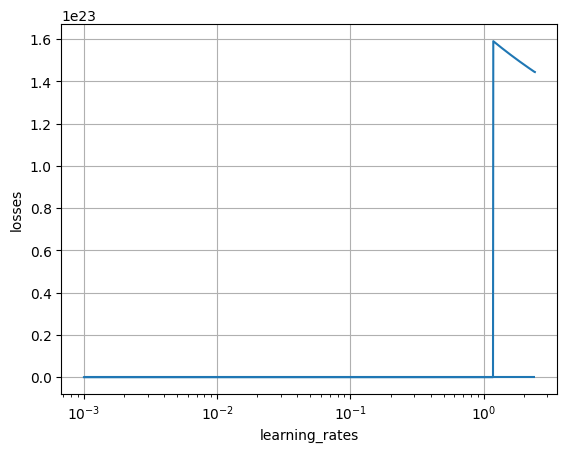

In [99]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.grid()
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))

plt.xlabel("learning_rates")
plt.ylabel("losses")

<Axes: >

(0.0, 1.0)

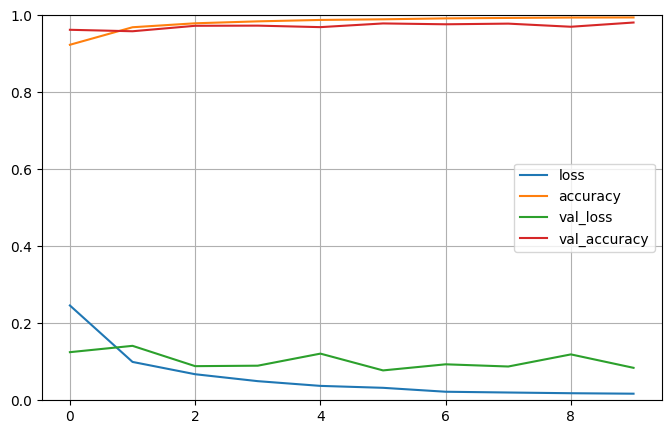

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [101]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28], name="input"),
                                 keras.layers.Dense(units=300, activation="relu", name="hidden1"),
                                 keras.layers.Dense(units=100, activation="relu", name="hidden2"),
                                 keras.layers.Dense(units=10, activation="softmax", name="output")])

In [102]:
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.SGD(learning_rate=3e-1),
              metrics = ["accuracy"])

In [103]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [106]:
early_stopping = keras.callbacks.EarlyStopping(patience=20)
check_point = keras.callbacks.ModelCheckpoint("my_model.h5")

model.fit(x_train, y_train, epochs=100,
         validation_data=(x_valid, y_valid),
         callbacks=[early_stopping, check_point])

Epoch 1/100
1563/1563 [==============================] - 50s 4ms/step - loss: 0.2441 - accuracy: 0.9235 - val_loss: 0.1290 - val_accuracy: 0.9620
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0991 - accuracy: 0.9690 - val_loss: 0.1098 - val_accuracy: 0.9660
Epoch 3/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0666 - accuracy: 0.9793 - val_loss: 0.0986 - val_accuracy: 0.9726
Epoch 4/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0495 - accuracy: 0.9841 - val_loss: 0.1191 - val_accuracy: 0.9673
Epoch 5/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0373 - accuracy: 0.9874 - val_loss: 0.0889 - val_accuracy: 0.9783
Epoch 6/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.0867 - val_accuracy: 0.9767
Epoch 7/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0926 - val_a

<Axes: >

(0.0, 1.0)

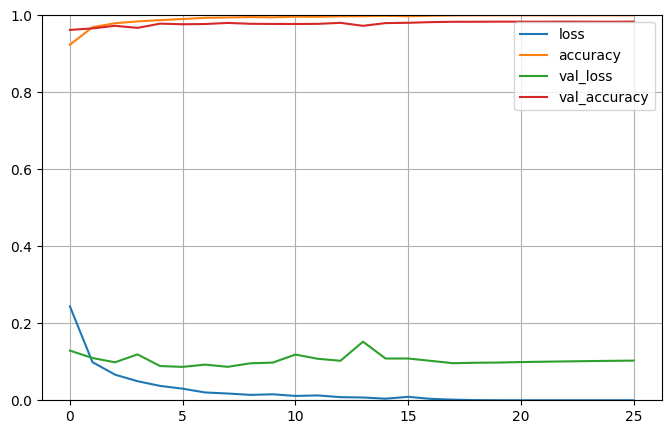

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [108]:
my_model = keras.models.load_model("my_model.h5")

In [110]:
my_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 24.4942 - accuracy: 0.9828


[24.494218826293945, 0.9828000068664551]